# Tree regressor - how to replacde the predict method using sklearn decsion trees

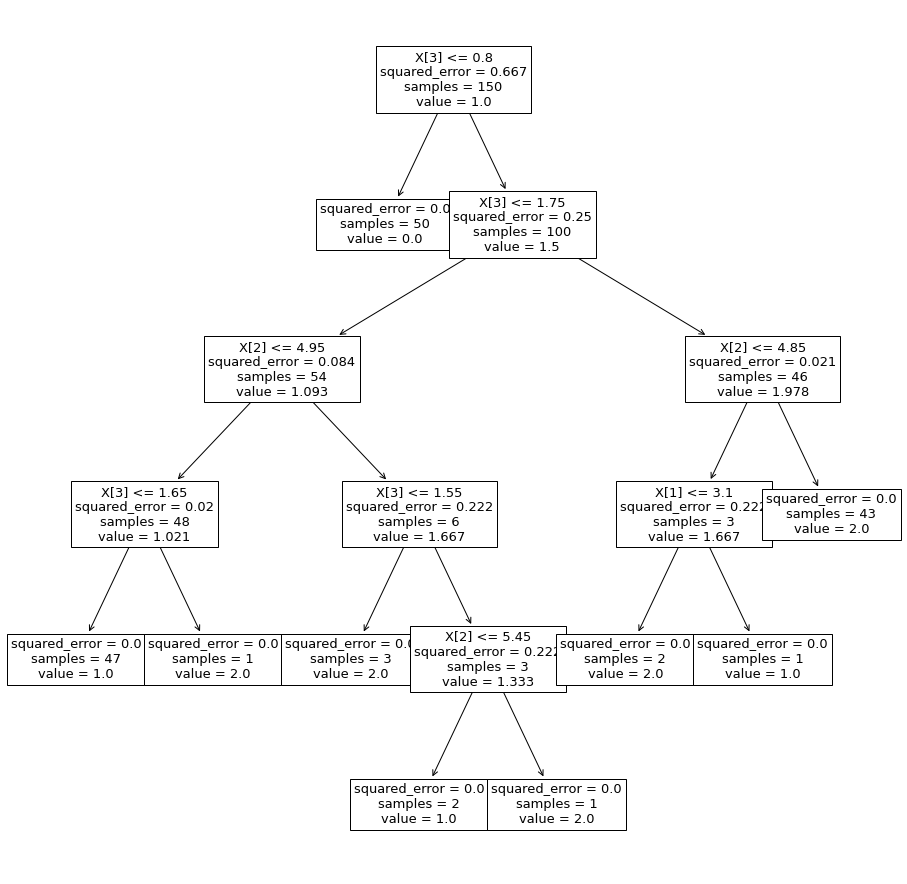

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn import tree

X, y = load_iris(return_X_y=True) # x = features; y= class

reg = DecisionTreeRegressor(random_state=0) #Regressor

reg.fit(X, y) # Train

plt.figure(figsize=(16,16))
tree.plot_tree(reg, fontsize=13)
plt.show()

# Implementation of predict


In [ ]:
import numpy
import random

def predict_proba_single(reg, x, alpha): # function return the leaf value
  children_left = reg.tree_.children_left
  children_right = reg.tree_.children_right
  feature_ids = reg.tree_.feature
  thresholds = reg.tree_.threshold
  values = reg.tree_.value

  index = 0

  while True:
    # step 1: which feature is relevant
    feature_id = feature_ids[index] # for root node feature_id is 3
    # step 2: get the relevant feature value
    feature_value = x[feature_id] # for root node feature value is 0.2
    # step 3: get the threshold
    threshold = thresholds[index] # for root node treshold is 0.8
    # step 4: get the node value
    value = values[index]
    # step 5: should we shift sides in the tree (split)
    shift = False
    if random.random() < alpha:
      shift = True
    # step 6: compare the feature_value with the feature_value
    if feature_value <= threshold:
      if shift:
        index = children_right[index]
      else:
        index = children_left[index]
    else:
      if shift:
        index = children_left[index]
      else:
        index = children_right[index]
    # if the index is -1 this is a leaf and we stop the loop
    if index == -1:
      break

  return value

In [ ]:
def predict(reg, X, alpha, n):
  results = []
  for x in X:
    preds = []
    for i in range(n):
      pred = predict_proba_single(reg, x, alpha)
      preds.append(pred[0][0])
    mean_preds = numpy.mean(preds)
    results.append(mean_preds)
  return numpy.array(results)

In [ ]:
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import roc_auc_score, median_absolute_error, accuracy_score, mean_squared_error

def run_cross_validation(regs, X, y): # regs is an array of regresors. In our case it will contain the sklearn classifier and the propose changes
  binary = len(numpy.unique(y)) == 2
  mses = {} #auc array repted 10 times (5*2) to avoid noise - reporting the mean result across all folds from all runs.
  med_abs_errs = {} #acc array repted 10 times (5*2) to avoid noise - reporting the mean result across all folds from all runs.
  for reg_name in regs:
    mses[reg_name] = []
    med_abs_errs[reg_name] = []
  rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=2652124) # k = 5*2
  for train_index, test_index in rkf.split(X):
    for reg_name in regs:
      reg = regs[reg_name]
      X_train, X_test = X[train_index], X[test_index] # Step 1
      y_train, y_test = y[train_index], y[test_index] # Step 1
      reg.fit(X_train, y_train) # Train - Step 2

      pred = reg.predict(X_test) # test
      mse = mean_squared_error(y_test, pred)
      med_abs_err = median_absolute_error(y_test, pred) # acc for 5 folds
      mses[reg_name].append(mse) # AUC for 10 folds - reporting the mean result across all folds from all runs.
      med_abs_errs[reg_name].append(med_abs_err) # acc for 10 folds - reporting the mean result across all folds from all runs.


  for reg_name in regs:
    mses[reg_name] = numpy.mean(mses[reg_name])
    med_abs_errs[reg_name] = numpy.mean(med_abs_errs[reg_name])
  return mses, med_abs_errs


In [ ]:
from google.colab import drive
import pandas
import os

drive.mount('/content/drive/',force_remount=True)
os.chdir('/content/drive/MyDrive/Colab Notebooks/')

Mounted at /content/drive/


In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

def plot(mses, med_abs_errs, title="", precision='.1f'):
  fig, ax = plt.subplots()
  names = list(mses.keys())
  values = list(mses.values())
  width = 0.75 # the width of the bars
  hbars = ax.barh(names, values, width, color=["blue", "red"])
  ax.set_xlim([0,2*max(values)])
  for p in hbars.patches:
    left, bottom, width, height = p.get_bbox().bounds
    value = format(width, precision) if width > 0 else '   0'
    plt.annotate(value, xy=((left+width) * 1.25 , bottom+height/2), ha='center', va='center',  fontsize=16)
  plt.title('MSE',  fontsize=20)
  fig.suptitle(title, fontsize=24, y=1.2)

  fig, ax = plt.subplots()
  names = list(med_abs_errs.keys())
  values = list(med_abs_errs.values())
  width = 0.75 # the width of the bars
  hbars = ax.barh(names, values, width, color=["blue", "red"])
  ax.set_xlim([0,2*max(values)])
  for p in hbars.patches:
    left, bottom, width, height = p.get_bbox().bounds
    value = format(width, precision) if width > 0 else '   0'
    plt.annotate(value, xy=((left+width) * 1.25 , bottom+height/2), ha='center', va='center',  fontsize=16)
  plt.title('Median Absolute Error',  fontsize=20)
  plt.show()

In [ ]:
from sklearn.tree import DecisionTreeRegressor

def get_regs(alpha, n):
  def predict_override(X):
    return predict(reg_p, X, alpha, n)

  reg_p = DecisionTreeRegressor()
  reg_p.predict = predict_override # override the predict_proba with the proposed changes
  return {"proposed changes": reg_p, "sklearn": DecisionTreeRegressor()}


In [ ]:
def load_concrete():
    features = ["0","1","2","3","4","5","6","7","8","9","10"]
    target = ["Class"]
    data = pandas.read_csv('regression.csv')
    X = data[features].to_numpy()
    y = data[target].to_numpy()
    return X, y

In [ ]:
def load_wine_quality():
    features = ["0","1","2","3","4","5","6","7","8","9","10"]
    target = ["Class"]
    data = pandas.read_csv('winequality-red.csv')
    X = data[features].to_numpy()
    y = data[target].to_numpy()
    return X, y

In [ ]:
def load_air_quality():
    features = ["0","1","2","3","4","5","6","7","8","9","10","11"]
    target = ["Class"]
    data = pandas.read_csv('AirQuality.csv').fillna(-9999)
    X = data[features].to_numpy()
    y = data[target].to_numpy()
    return X, y

In [ ]:
def load_parkinsons():
    features = ["0","1","2","3","4","5","6","7","8","9","10","11","12","13","14","15"]
    target = ["Class"]
    data = pandas.read_csv('/content/drive/MyDrive/Colab Notebooks/parkinsons.csv').fillna(-9999)
    X = data[features].to_numpy()
    y = data[target].to_numpy()
    return X, y

In [ ]:
from sklearn.preprocessing import LabelEncoder

def load_mushroom():
    data = pandas.read_csv('mushroom.csv')
    features = ["0","1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21"]
    target = ["Class"]
    strings = ["0","1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","Class"]
    data[strings] = data[strings].apply(LabelEncoder().fit_transform)
    X = data[features].to_numpy()
    y = data[target].to_numpy()
    return X, y

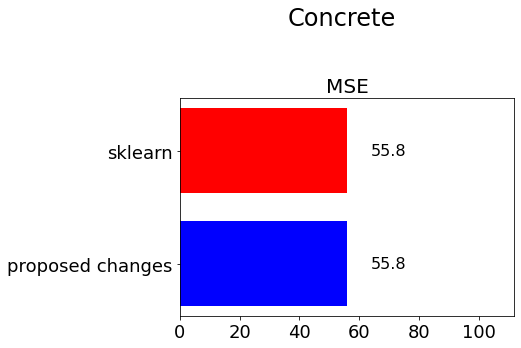

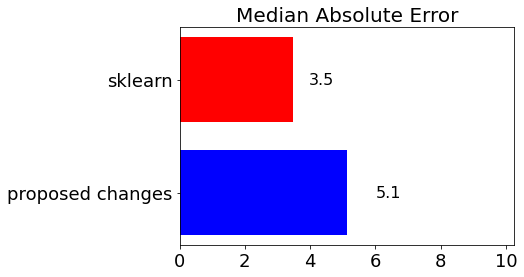

In [ ]:
X, y = load_concrete()

regs = get_regs(0.1, 100)

aucs, accs = run_cross_validation(regs, X, y)

plot(aucs, accs, "Concrete")

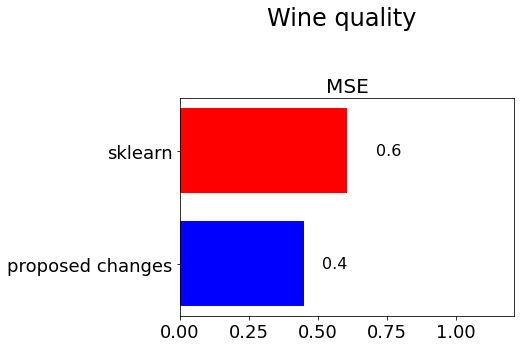

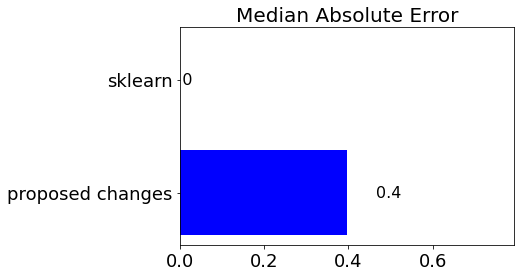

In [ ]:
X, y = load_wine_quality()

regs = get_regs(0.1, 100)

aucs, accs = run_cross_validation(regs, X, y)

plot(aucs, accs, "Wine quality")

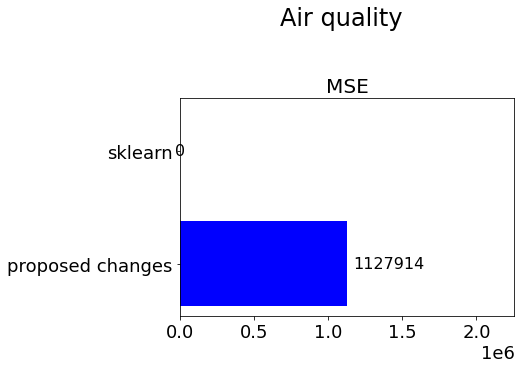

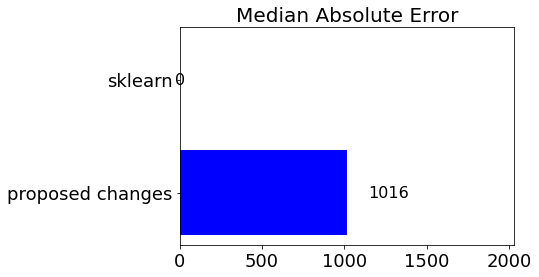

In [ ]:
X, y = load_air_quality()

regs = get_regs(0.1, 100)

aucs, accs = run_cross_validation(regs, X, y)

plot(aucs, accs, "Air quality")

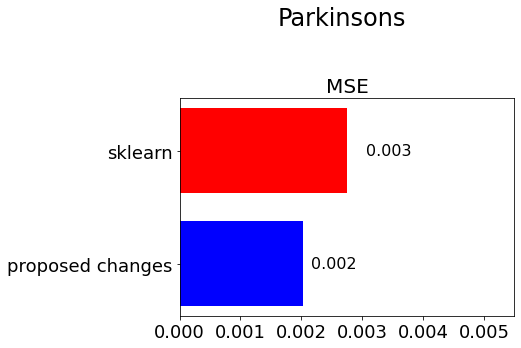

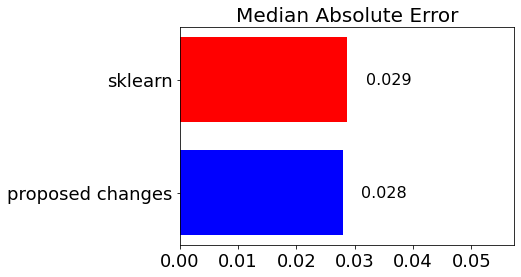

In [ ]:
#X, y = load_parkinsons()

#regs = get_regs(0.1, 100)

#aucs, accs = run_cross_validation(regs, X, y)

plot(aucs, accs, "Parkinsons", precision='.3f')

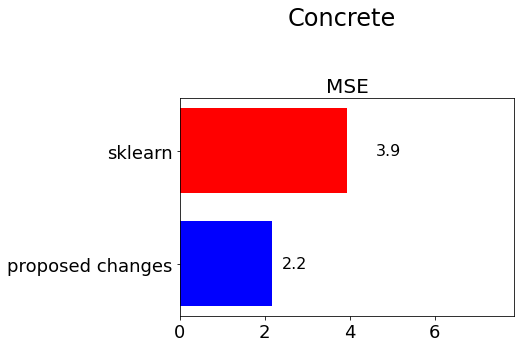

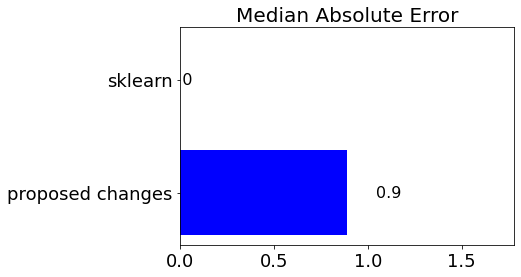

In [ ]:
X, y = load_mushroom()

regs = get_regs(0.1, 100)

aucs, accs = run_cross_validation(regs, X, y)

plot(aucs, accs, "Concrete")